<a href="https://colab.research.google.com/github/adityamishra5050/Sentiment-Analysis-of-Company-Reviews-/blob/main/Plain_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install torchtext
!pip install tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from tqdm import tqdm
#from torchtext.data import Field, LabelField, TabularDataset
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

d1 = os.chdir('/content/drive/MyDrive/DLP')
!ls

traindf = pd.read_csv('/content/drive/MyDrive/DLP/train.csv')
traindf.head()



Mounted at /content/drive
test.csv  test.csv.zip	train.csv  train.csv.zip  wordcloud11.png


,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [ ]:
from sklearn.model_selection import train_test_split

tokenizer=torchtext.data.utils.get_tokenizer('basic_english')
traindf['tokens']=traindf['Review'].apply(tokenizer)

vocab=torchtext.vocab.build_vocab_from_iterator(traindf['tokens'])
traindf['numeric_token'] = traindf['tokens'].apply(lambda x: [vocab[token] for token in x])



In [ ]:
traindf['Rating'].unique()

array([5, 3, 1, 4, 2])

In [ ]:
max_len=500

traindf['padded']=traindf['numeric_token'].apply(lambda x: x[:max_len] + [0]*(max_len-len(x)))
traindf['Rating1']=traindf['Rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

traindf.head()

,Id,Review,Rating,tokens,numeric_token,padded,Rating1
0,0,Very good value and a great tv very happy and ...,5,"[very, good, value, and, a, great, tv, very, h...","[29, 48, 390, 3, 6, 53, 126, 29, 142, 3, 33, 1...","[29, 48, 390, 3, 6, 53, 126, 29, 142, 3, 33, 1...",4
1,1,After 6 month still can't access my account,3,"[after, 6, month, still, can, ', t, access, my...","[58, 399, 165, 77, 74, 13, 36, 744, 8, 130]","[58, 399, 165, 77, 74, 13, 36, 744, 8, 130, 0,...",2
2,2,I couldn't make an official review on a produc...,1,"[i, couldn, ', t, make, an, official, review, ...","[4, 352, 13, 36, 224, 41, 2368, 334, 16, 6, 12...","[4, 352, 13, 36, 224, 41, 2368, 334, 16, 6, 12...",0
3,3,"Fantastic! Extremely easy to use website, fant...",5,"[fantastic, !, extremely, easy, to, use, websi...","[424, 17, 450, 79, 2, 75, 146, 5, 424, 870, 12...","[424, 17, 450, 79, 2, 75, 146, 5, 424, 870, 12...",4
4,4,So far annoyed as hell with this bt monthly pa...,1,"[so, far, annoyed, as, hell, with, this, bt, m...","[34, 367, 1869, 26, 1796, 14, 23, 120, 726, 71...","[34, 367, 1869, 26, 1796, 14, 23, 120, 726, 71...",0


In [ ]:
# Convert text and labels to tensors
#traindf['text'] = traindf['text'].apply(lambda x: [word_to_idx[word] for word in x])
#traindf['Rating'] = traindf['Rating'].astype('category').cat.codes
#texts = torch.LongTensor(data['text'].tolist())
#ratings = torch.LongTensor(traindf['Rating'].tolist())

In [ ]:

train_review, test_review, train_rating, test_rating = train_test_split(traindf['padded'], traindf['Rating1'], test_size=0.25, random_state=42)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1) # (batch_size, 1, seq_len, embedding_dim)
        x = [nn.functional.relu(conv(x)).squeeze(3) for conv in self.convs] # [(batch_size, num_filters, seq_len-fs+1), ...]
        x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x] # [(batch_size, num_filters), ...]
        x = torch.cat(x, 1) # (batch_size, num_filters * len(filter_sizes))
        x = self.fc(x) # (batch_size, num_classes)
        return x

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.data.iloc[index]), torch.tensor(self.labels.iloc[index])

    def __len__(self):
        return len(self.data)

In [ ]:
# Define the hyperparameters
EMBEDDING_DIM = 500
VOCAB_SIZE = len(vocab)
print(VOCAB_SIZE)
NUM_FILTERS = 10
FILTER_SIZES = [3, 4, 5]
NUM_CLASSES = 5
print(NUM_CLASSES)
BATCH_SIZE = 128
LR = 0.0001
NUM_EPOCHS = 10

42039
5


In [ ]:
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, FILTER_SIZES, NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_dataset = TextDataset(train_review, train_rating)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TextDataset(test_review, test_rating)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
train_L=[]
test_L=[]
#train_L.append(train_loss)

for epoch in range(NUM_EPOCHS):
    # Train the model for one epoch
    model.train()
    train_loss = 0
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        #print(torch.unique(outputs))
        #print(torch.unique(labels))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_L.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_accuracy += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    test_L.append(val_loss)



    val_accuracy /= len(test_dataset)

    # Print the loss and accuracy for the current epoch
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

100%|██████████| 352/352 [00:36<00:00,  9.75it/s]


Epoch 1 | Train Loss: 0.7750 | Val Loss: 0.6295 | Val Accuracy: 0.8106


100%|██████████| 352/352 [00:25<00:00, 13.97it/s]


Epoch 2 | Train Loss: 0.5853 | Val Loss: 0.5509 | Val Accuracy: 0.8378


100%|██████████| 352/352 [00:28<00:00, 12.41it/s]


Epoch 3 | Train Loss: 0.5213 | Val Loss: 0.5111 | Val Accuracy: 0.8475


100%|██████████| 352/352 [00:28<00:00, 12.54it/s]


Epoch 4 | Train Loss: 0.4789 | Val Loss: 0.4871 | Val Accuracy: 0.8536


100%|██████████| 352/352 [00:25<00:00, 13.62it/s]


Epoch 5 | Train Loss: 0.4472 | Val Loss: 0.4682 | Val Accuracy: 0.8563


100%|██████████| 352/352 [00:26<00:00, 13.50it/s]


Epoch 6 | Train Loss: 0.4229 | Val Loss: 0.4572 | Val Accuracy: 0.8591


100%|██████████| 352/352 [00:26<00:00, 13.12it/s]


Epoch 7 | Train Loss: 0.4022 | Val Loss: 0.4478 | Val Accuracy: 0.8611


100%|██████████| 352/352 [00:26<00:00, 13.07it/s]


Epoch 8 | Train Loss: 0.3840 | Val Loss: 0.4408 | Val Accuracy: 0.8642


100%|██████████| 352/352 [00:26<00:00, 13.40it/s]


Epoch 9 | Train Loss: 0.3669 | Val Loss: 0.4369 | Val Accuracy: 0.8647


100%|██████████| 352/352 [00:26<00:00, 13.51it/s]


Epoch 10 | Train Loss: 0.3515 | Val Loss: 0.4317 | Val Accuracy: 0.8654


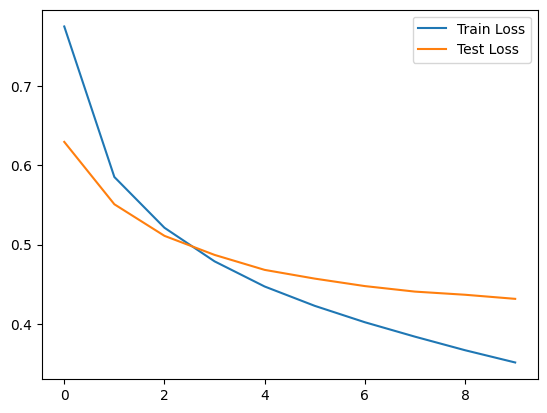

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_L, label='Train Loss')
plt.plot(test_L, label='Test Loss')
plt.legend()
plt.show()



In [ ]:
traindf2=traindf.copy()

In [ ]:
from gensim.utils import simple_preprocess
traindf2['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in traindf2['Review']]
traindf2.head()

,Id,Review,Rating,tokenized_text
0,0,Very good value and a great tv very happy and ...,5,"[very, good, value, and, great, tv, very, happ..."
1,1,After 6 month still can't access my account,3,"[after, month, still, can, access, my, account]"
2,2,I couldn't make an official review on a produc...,1,"[couldn, make, an, official, review, on, produ..."
3,3,"Fantastic! Extremely easy to use website, fant...",5,"[fantastic, extremely, easy, to, use, website,..."
4,4,So far annoyed as hell with this bt monthly pa...,1,"[so, far, annoyed, as, hell, with, this, bt, m..."


In [ ]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
traindf2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in traindf2['tokenized_text']]
print(traindf2.head())
#testdf2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in testdf2['tokenized_text']]
#testdf2

   Id                                             Review  Rating  \
0   0  Very good value and a great tv very happy and ...       5   
1   1        After 6 month still can't access my account       3   
2   2  I couldn't make an official review on a produc...       1   
3   3  Fantastic! Extremely easy to use website, fant...       5   
4   4  So far annoyed as hell with this bt monthly pa...       1   

                                      tokenized_text  \
0  [very, good, value, and, great, tv, very, happ...   
1    [after, month, still, can, access, my, account]   
2  [couldn, make, an, official, review, on, produ...   
3  [fantastic, extremely, easy, to, use, website,...   
4  [so, far, annoyed, as, hell, with, this, bt, m...   

                                      stemmed_tokens  
0  [veri, good, valu, and, great, tv, veri, happi...  
1    [after, month, still, can, access, my, account]  
2  [couldn, make, an, offici, review, on, product...  
3  [fantast, extrem, easi, to, us,

In [ ]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 0
OUTPUT_FOLDER = '/content/drive/MyDrive/DLP'

def make_word2vec_model(traindf2, padding, sg, min_count, size, workers, window):
    if  padding:
        print(len(traindf2))
        temp_df = pd.Series(traindf2['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        print(str(size))
        word2vec_file = OUTPUT_FOLDER + '2ata' + '_PAD.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)
    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

w2vmodel, word2vec_file = make_word2vec_model(traindf2, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)
print(w2vmodel)

60000
500
Word2Vec<vocab=20208, vector_size=500, alpha=0.025>


In [ ]:
traindf2['numeric_token'] = traindf2['stemmed_tokens'].apply(lambda x: [w2vmodel.wv[token] for token in x])
traindf2.head()

,Id,Review,Rating,tokenized_text,stemmed_tokens,numeric_token
0,0,Very good value and a great tv very happy and ...,5,"[very, good, value, and, great, tv, very, happ...","[veri, good, valu, and, great, tv, veri, happi...","[[0.29436257, 0.7792074, 0.55911607, -1.354732..."
1,1,After 6 month still can't access my account,3,"[after, month, still, can, access, my, account]","[after, month, still, can, access, my, account]","[[0.039907776, -0.34932074, -0.5595558, -1.008..."
2,2,I couldn't make an official review on a produc...,1,"[couldn, make, an, official, review, on, produ...","[couldn, make, an, offici, review, on, product...","[[-1.2253422, -0.7259483, -1.1771688, -0.01184..."
3,3,"Fantastic! Extremely easy to use website, fant...",5,"[fantastic, extremely, easy, to, use, website,...","[fantast, extrem, easi, to, us, websit, fantas...","[[1.0815247, 0.16047706, 0.25025064, 0.0021667..."
4,4,So far annoyed as hell with this bt monthly pa...,1,"[so, far, annoyed, as, hell, with, this, bt, m...","[so, far, annoi, as, hell, with, thi, bt, mont...","[[-0.14767525, -0.01497248, -0.1181563, -0.730..."


In [ ]:
max_len=500

traindf2['padded']=traindf2['numeric_token'].apply(lambda x: x[:max_len] + [0]*(max_len-len(x)))
traindf2['Rating1']=traindf2['Rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

traindf2.head()

,Id,Review,Rating,tokenized_text,stemmed_tokens,numeric_token,padded,Rating1
0,0,Very good value and a great tv very happy and ...,5,"[very, good, value, and, great, tv, very, happ...","[veri, good, valu, and, great, tv, veri, happi...","[[0.29436257, 0.7792074, 0.55911607, -1.354732...","[[0.29436257, 0.7792074, 0.55911607, -1.354732...",4
1,1,After 6 month still can't access my account,3,"[after, month, still, can, access, my, account]","[after, month, still, can, access, my, account]","[[0.039907776, -0.34932074, -0.5595558, -1.008...","[[0.039907776, -0.34932074, -0.5595558, -1.008...",2
2,2,I couldn't make an official review on a produc...,1,"[couldn, make, an, official, review, on, produ...","[couldn, make, an, offici, review, on, product...","[[-1.2253422, -0.7259483, -1.1771688, -0.01184...","[[-1.2253422, -0.7259483, -1.1771688, -0.01184...",0
3,3,"Fantastic! Extremely easy to use website, fant...",5,"[fantastic, extremely, easy, to, use, website,...","[fantast, extrem, easi, to, us, websit, fantas...","[[1.0815247, 0.16047706, 0.25025064, 0.0021667...","[[1.0815247, 0.16047706, 0.25025064, 0.0021667...",4
4,4,So far annoyed as hell with this bt monthly pa...,1,"[so, far, annoyed, as, hell, with, this, bt, m...","[so, far, annoi, as, hell, with, thi, bt, mont...","[[-0.14767525, -0.01497248, -0.1181563, -0.730...","[[-0.14767525, -0.01497248, -0.1181563, -0.730...",0


In [ ]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_rating, test_rating = train_test_split(traindf2['padded'], traindf2['Rating1'], test_size=0.25, random_state=42)

In [ ]:
# Define the hyperparameters
EMBEDDING_DIM = 500
VOCAB_SIZE  = len(w2vmodel.wv)
print(VOCAB_SIZE)
NUM_FILTERS = 10
FILTER_SIZES = [3, 4, 5]
NUM_CLASSES = 5
print(NUM_CLASSES)
BATCH_SIZE = 128
LR = 0.0001
NUM_EPOCHS = 10

20208
5


In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1) # (batch_size, 1, seq_len, embedding_dim)
        x = [nn.functional.relu(conv(x)).squeeze(3) for conv in self.convs] # [(batch_size, num_filters, seq_len-fs+1), ...]
        x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x] # [(batch_size, num_filters), ...]
        x = torch.cat(x, 1) # (batch_size, num_filters * len(filter_sizes))
        x = self.fc(x) # (batch_size, num_classes)
        return x

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        #data_point = torch.tensor(self.data[index])
        #label = torch.tensor(self.labels[index])
        #return data_point, label
        #return torch.tensor(self.data[index]), torch.tensor(self.labels[index])
        return torch.tensor(self.data.iloc[index]), torch.tensor(self.labels.iloc[index])

    def __len__(self):
        return len(self.data)

In [ ]:
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, FILTER_SIZES, NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_dataset = TextDataset(train_review, train_rating)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TextDataset(test_review, test_rating)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
train_L=[]
test_L=[]
#train_L.append(train_loss)

for epoch in range(NUM_EPOCHS):
    # Train the model for one epoch
    model.train()
    train_loss = 0
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        #print(torch.unique(outputs))
        #print(torch.unique(labels))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_L.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_accuracy += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    test_L.append(val_loss)
    val_accuracy /= len(test_dataset)

    # Print the loss and accuracy for the current epoch
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

  0%|          | 0/352 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_L, label='Train Loss')
plt.plot(test_L, label='Test Loss')
plt.legend()
plt.show()

